In [35]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import matplotlib.pyplot as plt

df = pd.read_csv('data.csv')


In [36]:
np.unique(df['sym'])

array(['AUDUSD', 'BTCUSD', 'C1', 'CL1', 'CO1', 'ETHUSD', 'EURUSD',
       'GBPUSD', 'GJGB1', 'GJGB10', 'GJGB30', 'GJGB5', 'HG1', 'HSI',
       'HXC', 'KC1', 'LA1', 'NDX', 'NG1', 'NKY', 'NZDUSD', 'RR1',
       'SHCOMP', 'SHSZ300', 'SPX', 'UKX', 'US1', 'US10', 'US1M', 'US30',
       'US5', 'USDCAD', 'USDCHF', 'USDCNH', 'USDDXY', 'USDIDR', 'USDINR',
       'USDJPY', 'USDKRW', 'USDNOK', 'USDPHP', 'USDSEK', 'USDSGD',
       'USDTHB', 'USDTWD', 'W1', 'XAGUSD', 'XAUUSD'], dtype=object)

In [38]:

asset_name = [
    'AUDUSD', 'EURUSD', 'GBPUSD', 'NZDUSD', 'USDCAD', 'USDCHF', 'USDJPY', 'USDNOK', 
    'USDSEK', 'XAGUSD', 'XAUUSD', 'USDSGD', 'USDDXY', 'US10', 'US1M', 'US30'
 ]

# Select only relevant columns and rows for pivoting
df_selected = df[df['sym'].isin(asset_name)][['Date', 'sym', 'Close']]

# Pivot the DataFrame: index='Date', columns='sym', values='Close'
pivot_df = df_selected.pivot(index='Date', columns='sym', values='Close')

# Forward fill missing values and drop any remaining nulls
pivot_df_filled = pivot_df.ffill().dropna()
# Reset index so the key column (Date) becomes a normal column
pivot_df_final = pivot_df_filled.reset_index()

pivot_df_final['US10'] = np.exp(-10*pivot_df_final['US10']/100)
pivot_df_final['US1M'] = np.exp(-(1/12)*pivot_df_final['US1M']/100)
pivot_df_final['US30'] = np.exp(-30*pivot_df_final['US30']/100)


pivot_df_final.head()

sym,Date,AUDUSD,EURUSD,GBPUSD,NZDUSD,US10,US1M,US30,USDCAD,USDCHF,USDDXY,USDJPY,USDNOK,USDSEK,USDSGD,XAGUSD,XAUUSD
0,2001-07-31,0.5100,0.8764,1.4252,0.4137,0.603264,0.996946,0.190787,1.5335,1.7265,117.18,125.00,9.1188,10.5804,1.8030,4.240,266.65
1,2001-08-01,0.5181,0.8810,1.4339,0.4174,0.602240,0.996963,0.190558,1.5361,1.7129,116.59,124.63,9.0932,10.5402,1.8041,4.240,267.55
2,2001-08-02,0.5205,0.8836,1.4315,0.4196,0.597441,0.996963,0.187608,1.5346,1.7090,116.16,123.70,9.0496,10.4375,1.7803,4.245,268.05
3,2001-08-03,0.5169,0.8844,1.4293,0.4182,0.597082,0.996980,0.187215,1.5290,1.7070,116.14,123.66,9.0315,10.3637,1.7770,4.240,268.55
4,2001-08-06,0.5175,0.8813,1.4183,0.4199,0.597321,0.996988,0.186822,1.5256,1.7102,116.46,123.90,9.0356,10.4187,1.7819,4.210,267.75


In [39]:
asset_cols = [col for col in pivot_df_final.columns if col != 'Date']
n_assets = len(asset_cols)
print(f'Number of assets: {n_assets}, Number of dates: {len(pivot_df_final)}')

Number of assets: 16, Number of dates: 6226


In [40]:
# Set Date as index for easier slicing
prices = pivot_df_final.set_index('Date')[asset_cols]

# Compute daily log returns (full dataset)
returns_full = np.log(prices / prices.shift(1)).dropna()

In [41]:
# Step 2: Function to compute PCA-based mu and sigma
def compute_pca_mu_sigma(returns_window):
    if len(returns_window) < n_assets:
        return None, None
    
    scaler = StandardScaler()
    returns_scaled = scaler.fit_transform(returns_window)
    
    pca = PCA()
    pca.fit(returns_scaled)
    explained_var = np.cumsum(pca.explained_variance_ratio_)
    n_factors = np.argmax(explained_var >= 0.8) + 1 or 1
    
    pca = PCA(n_components=n_factors)
    pca.fit(returns_scaled)
    
    betas = pca.components_.T
    factor_returns = pca.transform(returns_scaled)
    residuals = returns_scaled - np.dot(factor_returns, pca.components_)
    idio_vars = np.var(residuals, axis=0)
    
    factor_cov = np.diag(pca.explained_variance_)
    
    mu = np.mean(returns_window, axis=0).values
    sys_cov = np.dot(betas, np.dot(factor_cov, betas.T))
    scale_matrix = np.outer(scaler.scale_, scaler.scale_)
    sys_cov_original = sys_cov * scale_matrix
    idio_vars_original = idio_vars * scaler.scale_**2
    sigma = sys_cov_original + np.diag(idio_vars_original)
    
    return mu, sigma

In [42]:
def negative_sharpe(weights, mu, sigma):
    port_return = np.dot(weights, mu)
    port_std = np.sqrt(np.dot(weights.T, np.dot(sigma, weights)))
    return -port_return / port_std if port_std > 0 else np.inf

# def compute_optimal_weights(mu, sigma):
#     if mu is None or sigma is None or np.any(np.isnan(mu)) or np.any(np.isnan(sigma)):
#         return np.full(n_assets, np.nan)
    
#     constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
#     # bounds = tuple((-np.inf, np.inf) for _ in range(n_assets))  # Allow shorting
#     bounds = tuple((-0.3, 0.3) for _ in range(n_assets))  # Allow shorting

#     initial_weights = np.ones(n_assets) / n_assets
#     opt_result = minimize(negative_sharpe, initial_weights, args=(mu, sigma),
#                           method='SLSQP', bounds=bounds, constraints=constraints)
#     return opt_result.x if opt_result.success else np.full(n_assets, np.nan)

def compute_optimal_weights(mu, sigma):
    if mu is None or sigma is None or np.any(np.isnan(mu)) or np.any(np.isnan(sigma)):
        return np.full(n_assets, np.nan)
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # Sum of weights = 1
        {'type': 'ineq', 'fun': lambda w: 5 - np.sum(np.abs(w))}  # Leverage <= 5
    ]
    bounds = tuple((-0.3, 0.3) for _ in range(n_assets))  # Per-pair bounds
    initial_weights = np.ones(n_assets) / n_assets
    opt_result = minimize(negative_sharpe, initial_weights, args=(mu, sigma),
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return opt_result.x if opt_result.success else np.full(n_assets, np.nan)

In [43]:
# Step 3: Rolling weights
weight_cols = ['Weight_' + col for col in asset_cols]
weights_df = pd.DataFrame(index=prices.index, columns=weight_cols, dtype=float)
window_size = 60

for i in range(window_size, len(prices)):
    end_date = prices.index[i-1]
    start_date = prices.index[i-window_size] if i >= window_size else None
    if start_date is None:
        continue
    
    window_prices = prices.loc[start_date:end_date]
    returns_window = np.log(window_prices / window_prices.shift(1)).dropna()
    
    if len(returns_window) < window_size - 1:
        weights_df.loc[prices.index[i]] = np.full(n_assets, np.nan)
        continue
    
    mu, sigma = compute_pca_mu_sigma(returns_window)
    weights = compute_optimal_weights(mu, sigma)
    weights_df.loc[prices.index[i]] = weights


In [44]:
# Step 4: Join weights
updated_df = pivot_df_final.set_index('Date').join(weights_df).reset_index()

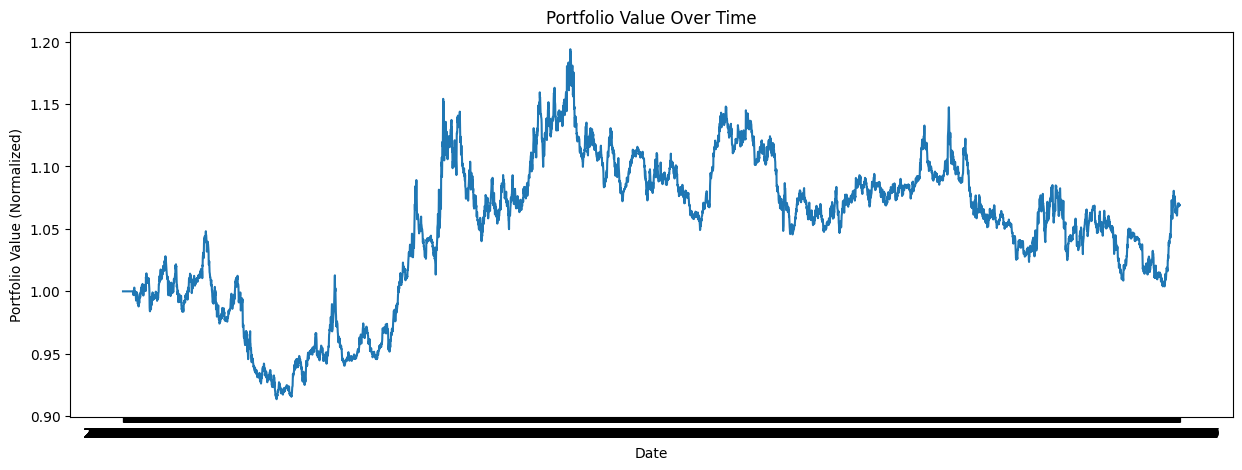

In [45]:
updated_df['Portfolio_Value'] = 1.0

asset_cols = [col for col in updated_df.columns if col not in ['Date', 'Portfolio_Value'] and not col.startswith('Weight_')]
weight_cols = ['Weight_' + col for col in asset_cols]

for i in range(60, len(updated_df)):
    weights = updated_df.iloc[i][weight_cols].values
    try:
        weights = np.array(weights, dtype=np.float64)
    except (ValueError, TypeError):
        continue
    if np.any(np.isnan(weights)):
        continue
    
    prices_today = updated_df.iloc[i][asset_cols].values
    prices_yest = updated_df.iloc[i-1][asset_cols].values if i > 0 else np.full(n_assets, np.nan)
    
    try:
        prices_today = np.array(prices_today, dtype=np.float64)
        prices_yest = np.array(prices_yest, dtype=np.float64)
    except (ValueError, TypeError):
        continue
    if np.any(np.isnan(prices_today)) or np.any(np.isnan(prices_yest)):
        continue
    
    daily_returns = (prices_today / prices_yest) - 1
    port_return = np.sum(weights * daily_returns)
    updated_df.iloc[i, updated_df.columns.get_loc('Portfolio_Value')] = \
        updated_df.iloc[i-1]['Portfolio_Value'] * (1 + port_return)
    
plt.figure(figsize=(15, 5))
plt.plot(updated_df['Date'], updated_df['Portfolio_Value'])
plt.xlabel('Date')
plt.ylabel('Portfolio Value (Normalized)')
plt.title('Portfolio Value Over Time')
# plt.grid(True)
plt.show()